In [1]:
from transformers import pipeline
import numpy as np
import pandas as pd
from datasets import Dataset, load_dataset, ClassLabel
import torch
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

#Seeding for deterministic results i.e. showing same output 
RANDOM_SEED = 64
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)
   torch.cuda.manual_seed_all(RANDOM_SEED) 
   torch.backends.cudnn.deterministic = True  
   torch.backends.cudnn.benchmark = False

/home/njfernandez/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
comfunctions_basic = 'comfunct_basic.txt'
df = pd.read_csv(comfunctions_basic, delimiter=";")
df = df[~df['function'].isin(['NOT_INTERESTED', 'BORED','NOT_IMPORTANT', 'REFUSE', 'WARN', 
                              'COMPLAIN', 'THREATEN', 'UNWILLING', 'DISTRUST' ])].rename(columns={"function": "functions"})


In [3]:
unique_labels = df["functions"].unique().tolist()
function_labels = ClassLabel(names=unique_labels)

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([function_labels.names])
labels_classes = mlb.classes_
labels_classes

array(['ANGRY', 'DISAGREE', 'DISAPPOINTED', 'DISLIKE', 'NOT_APPROVE',
       'NOT_CORRECT', 'OTHER', 'PESSIMISTIC', 'WORRIED'], dtype=object)

In [4]:
function_mapping = {'OTHER': ['admiration', 'approval', 'gratitude', 'amusement', 'curiosity', 'embarrassment', 'love', 'optimism', 'joy', 
                              'realization', 'confusion', 'caring', 'excitement', 'surprise', 'desire', 'pride', 'relief', 'neutral'], 
           'NOT_INTERESTED': [''], 
           'DISLIKE':['disgust', 'annoyance'], 
           'NOT_CORRECT': ['disapproval'], 
           'PESSIMISTIC':['grief', 'remorse', 'sadness'], 
           'WORRIED':['fear', 'nervousness'], 
           'ANGRY': ['anger'], 
           'DISAPPOINTED': ['disappointment'], 
           'BORED': [''], 
           'NOT_APPROVE':['disapproval'], 
           'NOT_IMPORTANT': [''], 
           'DISAGREE': ['disapproval'], 
           'WARN': [''], 
           'COMPLAIN': [''], 
           'THREATEN': [''], 
           'UNWILLING': [''], 
           'DISTRUST' : [''],
           'REFUSE': [''] }

mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

go_emotions = load_dataset("go_emotions").remove_columns("id")
def adjust_labels(batch):
    batch['emotions'] = [[] for _ in range(len(batch['text']))]
    for i, item in enumerate(batch["labels"]):
        batch["emotions"][i] = [mapping[label] for label in batch["labels"][i]]
    return batch

go_emotions = go_emotions.map(adjust_labels, batched=True)
def map_labels(batch):
    batch['functions'] = [[] for _ in range(len(batch['text']))]
    for i, item in enumerate(batch["emotions"]):
        batch["functions"][i] = [key for key,value in function_mapping.items() if any(emotion in batch["emotions"][i] for emotion in value)]
    return batch
go_emotions = go_emotions.map(map_labels, batched=True).remove_columns("labels")

# Convert labels to one hot enconding vectors
def one_hot_encoding(batch):
    label_ids = mlb.transform(batch['functions'])
    return {"label_ids":label_ids}
go_emotions = go_emotions.map(one_hot_encoding, batched=True)

def get_predicted_labels(batch):
    transformed_into_label_names = mlb.inverse_transform(np.array(batch['pred_label_ids']))
    return  {"predicted_labels": list(map(list, transformed_into_label_names))}

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (/home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
100%|██████████| 3/3 [00:00<00:00, 701.27it/s]
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-1c4d70c4ecc5a4bd.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-8f90b5d8ac946ce8.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-f0dc721270e34384.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified

In [5]:
zero_shot_model='MoritzLaurer/mDeBERTa-v3-base-mnli-xnli'
candidate_labels= {#"lack of interest": "NOT_INTERESTED",
                   #"boredom": "BORED",
                   "disgust": "DISLIKE", 
                   "incorrectness": "NOT_CORRECT", 
                   "sadness": "PESSIMISTIC", 
                   "fear": "WORRIED", 
                   "anger": "ANGRY", 
                   "disappointment": "DISAPPOINTED",
                   #"complaint": "COMPLAIN",
                   "disapproval": "NOT_APPROVE",
                   #"unimportance": "NOT_IMPORTANT", 
                   "disagreement": "DISAGREE",
                   #"refusal": "REFUSE",
                  #"warning": "WARN", 
                  #"threat": "THREATEN",
                  #"unwillingness": "UNWILLING",
                  #"distrust": "DISTRUST",
                  "joy, surprise or other emotion": "OTHER"}

h_ts = ['This person feels {}.', 'This person conveys {}.','This person shows {}.','This person expresses {}.', 
        'This text is {}.', 'This text is about {}.', 'This text shows {}.', 'This text expresses {}.', 'This text conveys {}.',
       'The communicative function of this text is {}.', 'The communicative intention of this text is {}.', 'The emotion of this text is {}.', 
        'The emotion expressed in this text is {}.'] # the templates used

def zero_shot_pipeline(example):
    output = classifier(example['text'], candidate_labels=list(candidate_labels.keys()), hypothesis_template=ht, multi_label=True)
    labels_scores = {candidate_labels[key]: score for key, score in zip(output['labels'], output['scores'])}
    labels_scores = sorted(labels_scores.items(), key=lambda kv: kv[1], reverse=True)    
    labels = [label for label, _ in labels_scores]
    scores = [score for _, score in labels_scores]
    return {"predicted_labels_items": labels, "predicted_labels_scores": scores}


In [6]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels_items"], example["predicted_labels_scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels_items"][i])
    else:
                raise ValueError("Set either `threshold` or `topk`.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
            y_true, y_pred, target_names=mlb.classes_, zero_division=0, 
            output_dict=True)

/home/njfernandez/.local/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Parameter 'function'=<function zero_shot_pipeline at 0x7eff89ed0b80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. S

This person feels {}.


  0%|          | 10/5426 [00:01<12:16,  7.35ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 5426/5426 [00:01<00:00, 5141.77ex/s]


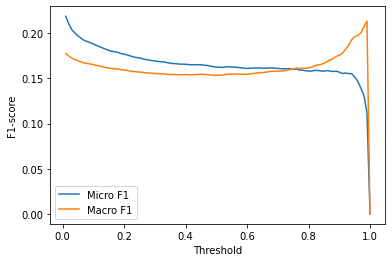

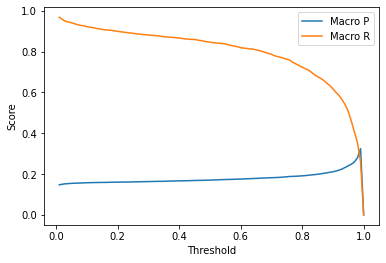

Best threshold (micro): 0.01 with F1-score 0.22.
Best threshold (macro): 0.99 with F1-score 0.21.
Best threshold (macro-Precision): 0.99 with macroP-score 0.32.
Best threshold (macro-Recall): 0.01 with macroR-score 0.97.
This person conveys {}.


  0%|          | 0/5426 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 5426/5426 [00:00<00:00, 5654.40ex/s]


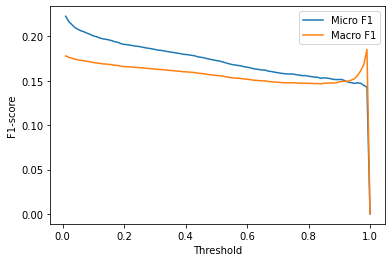

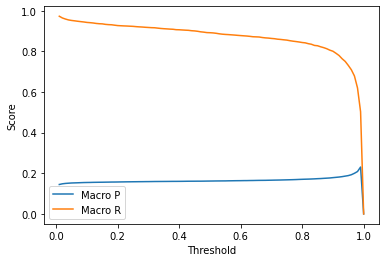

Best threshold (micro): 0.01 with F1-score 0.22.
Best threshold (macro): 0.99 with F1-score 0.19.
Best threshold (macro-Precision): 0.99 with macroP-score 0.23.
Best threshold (macro-Recall): 0.01 with macroR-score 0.97.
This person shows {}.


  0%|          | 0/5426 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 71%|███████   | 3850/5426 [07:15<02:59,  8.78ex/s]s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 5426/5426 [00:00<00:00, 5781.05ex/s]


100%|██████████| 5426/5426 [00:01<00:00, 5176.34ex/s]


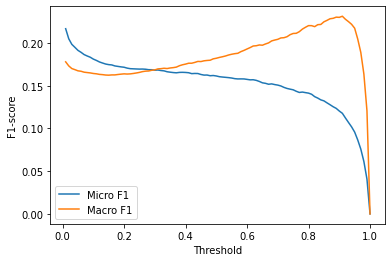

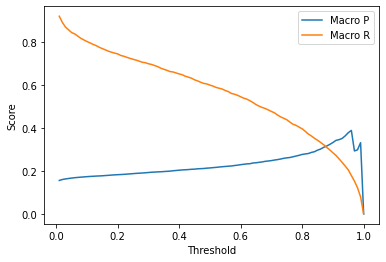

Best threshold (micro): 0.01 with F1-score 0.22.
Best threshold (macro): 0.91 with F1-score 0.23.
Best threshold (macro-Precision): 0.9600000000000001 with macroP-score 0.39.
Best threshold (macro-Recall): 0.01 with macroR-score 0.92.
This text shows {}.


  0%|          | 0/5426 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  7%|▋         | 371/5426 [00:42<09:23,  8.98ex/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


100%|██████████| 5426/5426 [00:01<00:00, 5106.19ex/s]


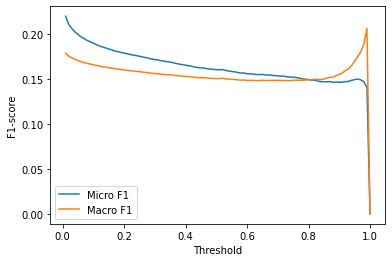

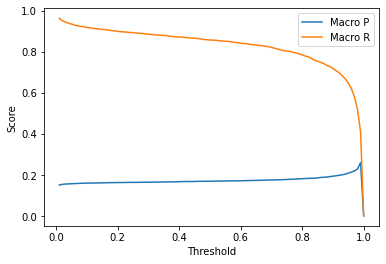

Best threshold (micro): 0.01 with F1-score 0.22.
Best threshold (macro): 0.99 with F1-score 0.21.
Best threshold (macro-Precision): 0.99 with macroP-score 0.26.
Best threshold (macro-Recall): 0.01 with macroR-score 0.96.
This text conveys {}.


  0%|          | 0/5426 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 54%|█████▍    | 2951/5426 [05:24<04:52,  8.48ex/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 68%|██████▊   | 3715/5426 [00:00<00:00, 5729.71ex/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_li

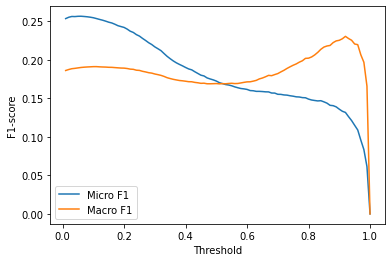

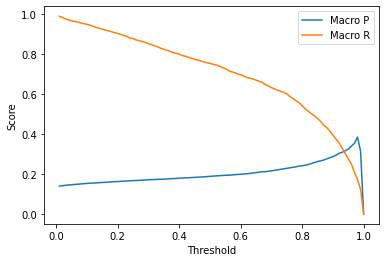

Best threshold (micro): 0.060000000000000005 with F1-score 0.26.
Best threshold (macro): 0.92 with F1-score 0.23.
Best threshold (macro-Precision): 0.98 with macroP-score 0.38.
Best threshold (macro-Recall): 0.01 with macroR-score 0.99.


In [7]:
# Use GPU if available
classifier = pipeline('zero-shot-classification', model=zero_shot_model, device=0, fp16=True, batch_size=64)

for ht in h_ts:
    print(ht)
    go_emotions['validation'] = go_emotions['validation'].map(zero_shot_pipeline)
    macros, micros, macroprecision, macrorecall = [], [], [], []
    thresholds = np.linspace(0.01, 1, 100)
    for threshold in thresholds:
        ds_zero_shot = go_emotions['validation'].map(get_preds,
                                        fn_kwargs={"threshold": threshold})
        clf_report = get_clf_report(ds_zero_shot)
        micros.append(clf_report["micro avg"]["f1-score"])
        macros.append(clf_report["macro avg"]["f1-score"])
        macroprecision.append(clf_report['macro avg']['precision'])
        macrorecall.append(clf_report['macro avg']['recall'])
    plt.plot(thresholds, micros, label="Micro F1")
    plt.plot(thresholds, macros, label="Macro F1")
    plt.xlabel("Threshold")
    plt.ylabel("F1-score")
    plt.legend(loc="best")
    plt.show()
    plt.plot(thresholds, macroprecision, label="Macro P")
    plt.plot(thresholds, macrorecall, label="Macro R")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()
    best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
    print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
    best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
    print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.')
    best_t, best_macro_P = thresholds[np.argmax(macroprecision)], np.max(macroprecision)
    print(f'Best threshold (macro-Precision): {best_t} with macroP-score {best_macro_P:.2f}.')
    best_t, best_macro_R = thresholds[np.argmax(macrorecall)], np.max(macrorecall)
    print(f'Best threshold (macro-Recall): {best_t} with macroR-score {best_macro_R:.2f}.')

In [12]:
for ht in h_ts:
    thr = 0.9
    print(ht)
    go_emotions['test'] = go_emotions['test'].map(zero_shot_pipeline)    
    thresholds = np.linspace(0.01, 1, 100)
    ds_zero_shot = go_emotions['test'].map(get_preds, fn_kwargs={'threshold': thr})
    clf_report = get_clf_report(ds_zero_shot)
    print(clf_report)
    df = pd.DataFrame(clf_report).transpose()
    with open(f"classification_report_functions_goemotions_zero_shot_threshold={thr}_ht={ht}.csv", 'w') as csv_file:
        df.to_csv(path_or_buf=csv_file)        
    ds_zero_shot = ds_zero_shot.map(get_predicted_labels, batched=True)
    ds_zero_shot.set_format("pandas")
    cols = ["text", "emotions", "functions", "predicted_labels"]
    df_test = ds_zero_shot[:][cols]
    df_test.to_csv(f"preds_functions_goemotions_zero_shot_threshold={thr}_ht={ht}.tsv",header =True, sep = '\t',index=False)

This person feels {}.


  0%|          | 0/5427 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 5427/5427 [00:00<00:00, 6221.71ex/s]


{'ANGRY': {'precision': 0.0927703134996801, 'recall': 0.7323232323232324, 'f1-score': 0.16467915956842702, 'support': 198}, 'DISAGREE': {'precision': 0.06840684068406841, 'recall': 0.8539325842696629, 'f1-score': 0.12666666666666668, 'support': 267}, 'DISAPPOINTED': {'precision': 0.08582089552238806, 'recall': 0.609271523178808, 'f1-score': 0.15044971381847916, 'support': 151}, 'DISLIKE': {'precision': 0.24566929133858267, 'recall': 0.36363636363636365, 'f1-score': 0.29323308270676696, 'support': 429}, 'NOT_APPROVE': {'precision': 0.08666386201093816, 'recall': 0.7715355805243446, 'f1-score': 0.15582450832072617, 'support': 267}, 'NOT_CORRECT': {'precision': 0.11299852289512555, 'recall': 0.5730337078651685, 'f1-score': 0.18877236273904996, 'support': 267}, 'OTHER': {'precision': 0.9857651245551602, 'recall': 0.06315549475604196, 'f1-score': 0.11870580672809085, 'support': 4386}, 'PESSIMISTIC': {'precision': 0.17277486910994763, 'recall': 0.7783018867924528, 'f1-score': 0.2827763496143

100%|██████████| 6/6 [00:00<00:00, 114.85ba/s]


This person conveys {}.


  0%|          | 0/5427 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 98%|█████████▊| 5301/5427 [09:31<00:13,  9.20ex/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 88%|████████▊ | 4802/5427 [08:37<01:07,  9.29ex/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limi